In [2]:
import numpy as np

from speechbrain.lobes.beamform_multimic import DelaySum_Beamformer
import os
import glob
from pathlib import Path
import soundfile as sf
import torch
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
from speechbrain.processing.features import (
    STFT,
    ISTFT,
    Complex_STFT,
)
from pydub import AudioSegment
from beamformer import 

In [3]:
beamformer=DelaySum_Beamformer()
# stft = Complex_STFT(sample_rate=16000)
# istft = ISTFT(sample_rate=16000)

In [4]:
meeting_folder = "/Users/ccui/Desktop/POC/asteroid_results/AMIx/TAC/2ch/ex_71"
wavs = os.listdir(meeting_folder)
array1_list = []
# array2_list = []

for wav in wavs:
    mic_type = wav.split(".")[0]
    wav_path = os.path.join(meeting_folder, wav)
    if "mixture" in mic_type:
        # print(wav_path)
        # array_path_list.append(str(Path(wav)))
        array_np, fs = sf.read(
            wav_path,
            dtype="float32",
        )
        array = torch.from_numpy(array_np).unsqueeze(0)
        array1_list.append(array)
    elif "estimate" in mic_type:
        pretrained, fs = sf.read(
            wav_path,
            dtype="float32",
        )
    elif mic_type == "s1":
        source, fs = sf.read(
            wav_path,
            dtype="float32",
        )
array1_list = torch.cat(array1_list, 0).float()
# array2_list = torch.cat(array2_list, 0).float()
# array1_list = array1_list[:, 16000 * 9 : 16000 * 15]
# array2_list = array2_list[:, 16000 * 9 : 16000 * 15]
print(array1_list.shape)
# print(array2_list.shape)

torch.Size([1, 64000])


In [5]:
meeting_folder = "/Users/ccui/Desktop/POC/asteroid_results/AMIx/TAC/joint/2ch_10_jeanzay"
wavs = os.listdir(meeting_folder)
array1_list = []
# array2_list = []

for wav in wavs:
    meeting = wav.split("_")[-2]
    mic_type = wav.split("_")[-1]
    wav_path = os.path.join(meeting_folder, wav)
    if meeting =="7":
        # if "mix" in mic_type:
        #     # print(wav_path)
        #     # array_path_list.append(str(Path(wav)))
        #     array_np, fs = sf.read(
        #         wav_path,
        #         dtype="float32",
        #     )
        #     array = torch.from_numpy(array_np).unsqueeze(0)
        #     array1_list.append(array)
        if "source1Est" in mic_type:
            neural, fs = sf.read(
                wav_path,
                dtype="float32",
            )
        # elif mic_type == "source1.wav":
        #     source, fs = sf.read(
        #         wav_path,
        #         dtype="float32",
            # )
# array1_list = torch.cat(array1_list, 0).float()
# array2_list = torch.cat(array2_list, 0).float()
# array1_list = array1_list[:, 16000 * 9 : 16000 * 15]
# array2_list = array2_list[:, 16000 * 9 : 16000 * 15]
# print(array1_list.shape)
# print(array2_list.shape)

In [8]:
wav_path = "/Users/ccui/Desktop/speechbrain/recipes/AMI/ASR/data_processing/speech_enhanced.wav"
neural, fs = sf.read(
    wav_path,
    dtype="float32",
)

In [9]:
neural = np.array([(neural / np.max(np.abs(neural))) * max(abs(array_np))], np.float32).squeeze(0)

In [13]:
Audio(data=neural, rate=16000)

In [7]:
def beamforming(signal):
    batch = signal.permute(1,0).unsqueeze(0)
    beamformed_array1=beamformer(batch)
    beamformed_array1=beamformed_array1.squeeze(-1).squeeze(0)
    return beamformed_array1

In [8]:
beamformed_array1 = beamforming(array1_list)


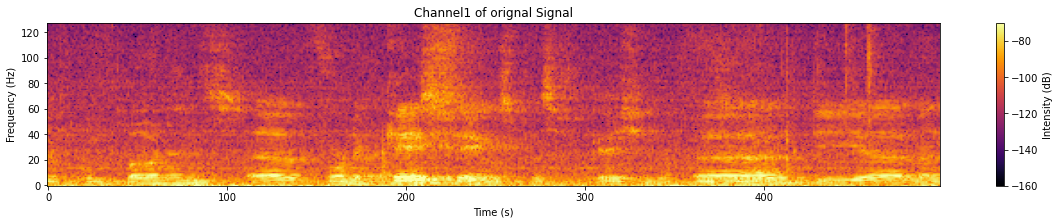

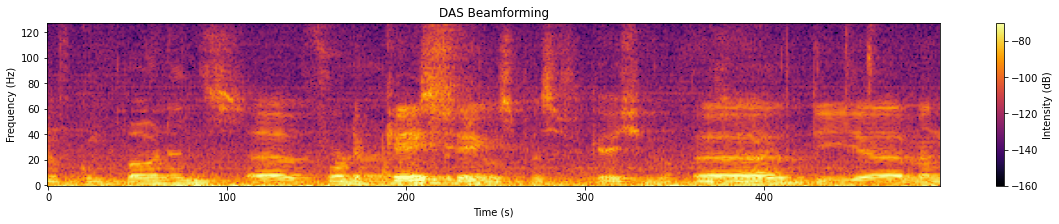

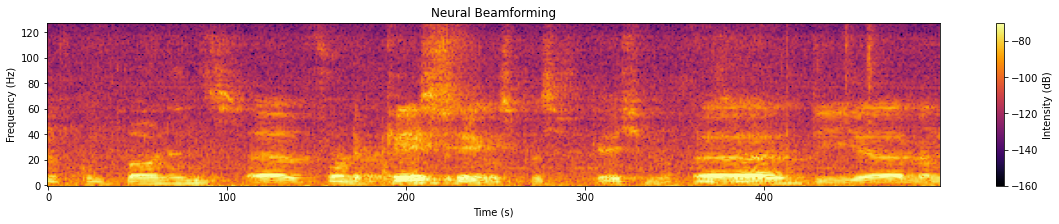

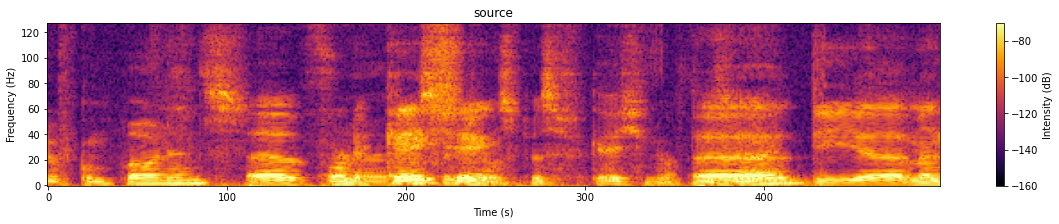

In [21]:
def get_spect(signal, title):
    plt.figure(figsize=(20, 3))
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)
    # norm = Normalize(vmin=-150, vmax=-60)
    # plt.imshow(sxx, aspect='auto', cmap='inferno', vmin=-150, vmax=-60)
    plt.imshow(sxx, aspect="auto", cmap="inferno", vmin=-160, vmax=-70)
    plt.gca().invert_yaxis()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.colorbar(label="Intensity (dB)")
    plt.show()


get_spect(array1_list[0], "Channel1 of orignal Signal")
get_spect(beamformed_array1, "DAS Beamforming")
get_spect(neural, "Neural Beamforming")
get_spect(source, "source")

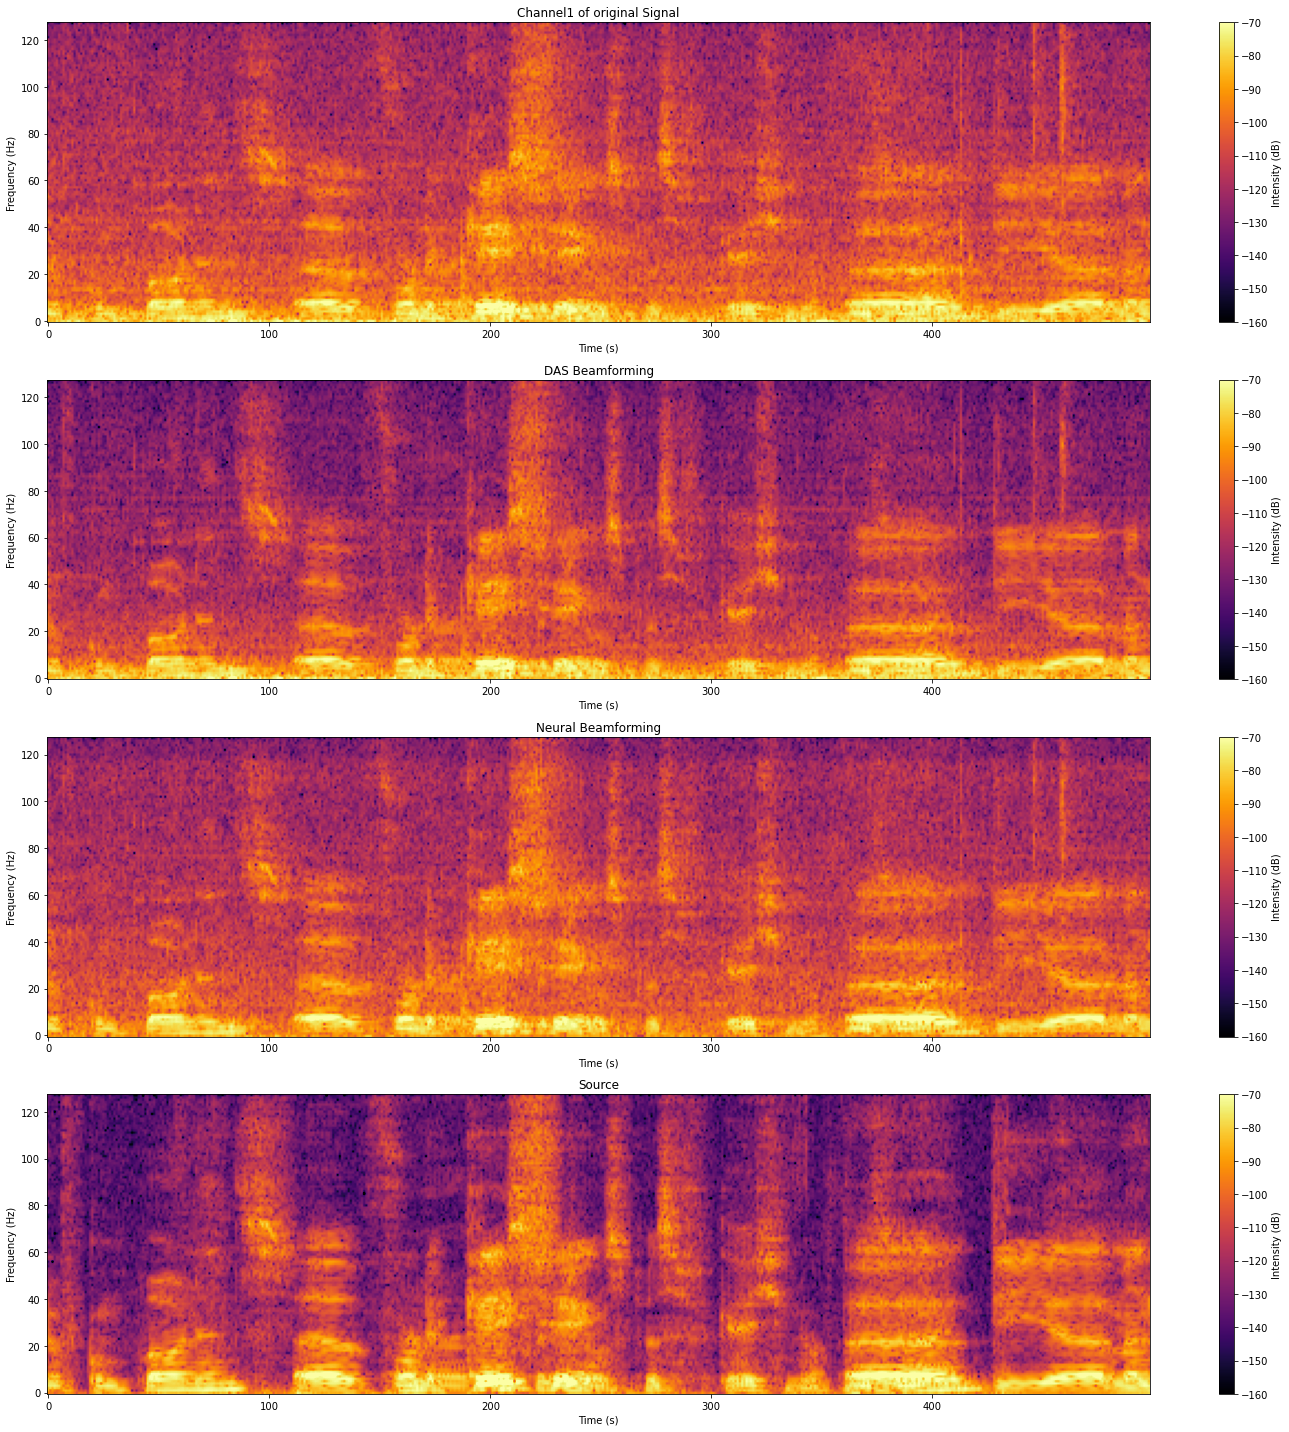

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def get_spect(signal, title, ax):
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)

    # Plot the spectrogram on the specified axis
    im = ax.imshow(sxx, aspect="auto", cmap="inferno", vmin=-160, vmax=-70)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    return im


# Create a 4-row plot
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# Plot each spectrogram on a separate row
im1 = get_spect(array1_list[0], "Channel1 of original Signal", axes[0])
im2 = get_spect(beamformed_array1, "DAS Beamforming", axes[1])
im3 = get_spect(neural, "Neural Beamforming", axes[2])
im4 = get_spect(source, "Source", axes[3])

# Adjust layout to prevent clipping of axis labels
plt.tight_layout()

# Add colorbars to the right of the plots
cbar1 = plt.colorbar(im1, ax=axes[0], label="Intensity (dB)")
cbar2 = plt.colorbar(im2, ax=axes[1], label="Intensity (dB)")
cbar3 = plt.colorbar(im3, ax=axes[2], label="Intensity (dB)")
cbar4 = plt.colorbar(im4, ax=axes[3], label="Intensity (dB)")

# Show the plot
plt.show()

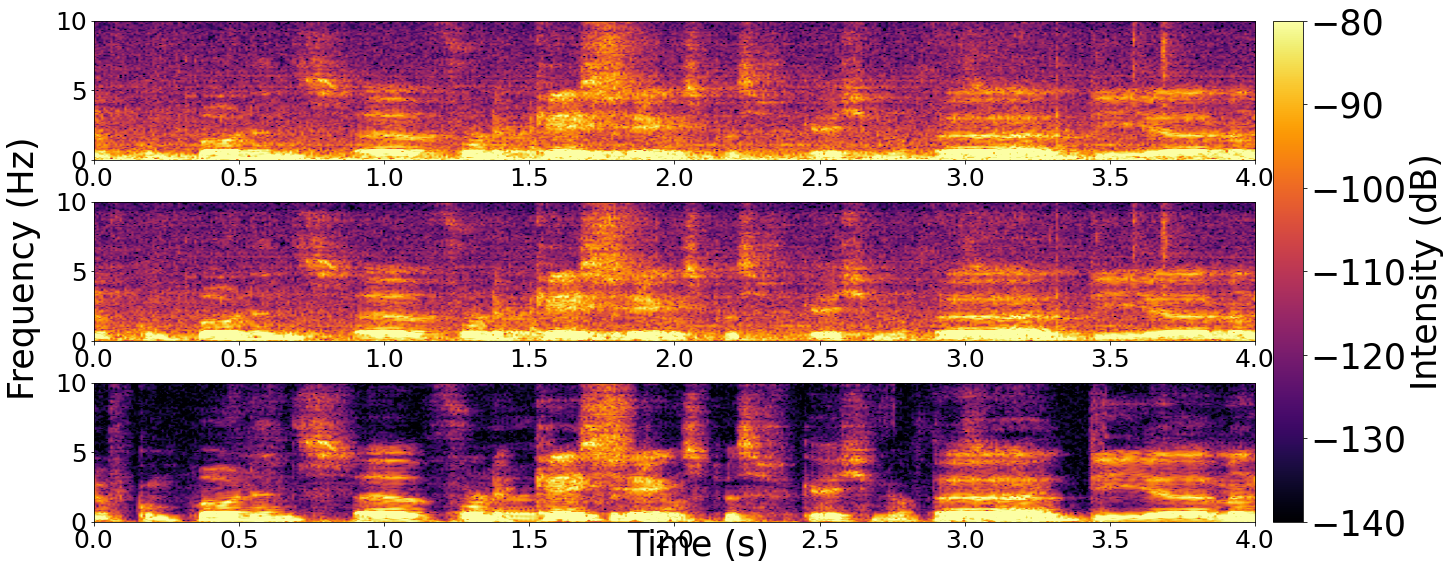

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


def get_spect(signal, title, ax):
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)

    # Plot the spectrogram on the specified axis
    im = ax.imshow(sxx, aspect="auto", cmap="inferno", vmin=-140, vmax=-80, extent=[0, 4, 10, 0])
    ax.invert_yaxis()
    ax.set_title(title, fontsize=39)
    # ax.set_xlabel("Time (s)", fontsize=25)
    # ax.set_ylabel("Frequency (Hz)", fontsize=25)
    ax.tick_params(axis="both", labelsize=25)
    return im


# Create a 4-row plot with a shared colorbar
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[19.5, 0.5])  # Add an extra column for the colorbar

# Plot each spectrogram on a separate row
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[2, 0])
# ax4 = plt.subplot(gs[3, 0])

# im1 = get_spect(array1_list[0], "Channel 1 of the original signal", ax1)
# # im2 = get_spect(beamformed_array1, "Signal after DAS Beamforming", ax2)
# im3 = get_spect(neural, "Signal after Joint Trained Neural Beamforming", ax2)
# im4 = get_spect(source, "Ground truth (aligned Headset)", ax3)

im1 = get_spect(array1_list[0], "", ax1)
# im2 = get_spect(beamformed_array1, "", ax2)
im3 = get_spect(neural, "", ax2)
im4 = get_spect(source, "", ax3)

# Set a common xlabel and ylabel
fig.text(0.5, 0.001, "Time (s)", ha="center", fontsize=35)  # Common xlabel
fig.text(
    0.02, 0.5, "Frequency (Hz)", va="center", rotation="vertical", fontsize=35
)  # Common ylabel


# Adjust layout to prevent clipping of axis labels and move the subplots inward
plt.subplots_adjust(left=0.08, right=0.99, top=0.93, bottom=0.06, hspace=0.3)


# Add a common colorbar to the right of the plots
cax = plt.subplot(gs[:, 1])
cbar = plt.colorbar(im4, cax=cax, label="Intensity (dB)")

# Manually adjust the position of the colorbar
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0 - 0.07, cax_pos.y0, cax_pos.width, cax_pos.height])

cbar.ax.yaxis.label.set_fontsize(35)
# Increase font size for colorbar
cbar.ax.tick_params(labelsize=35)
# Show the plot
plt.savefig("beanformers_joint.png", bbox_inches="tight")
plt.show()

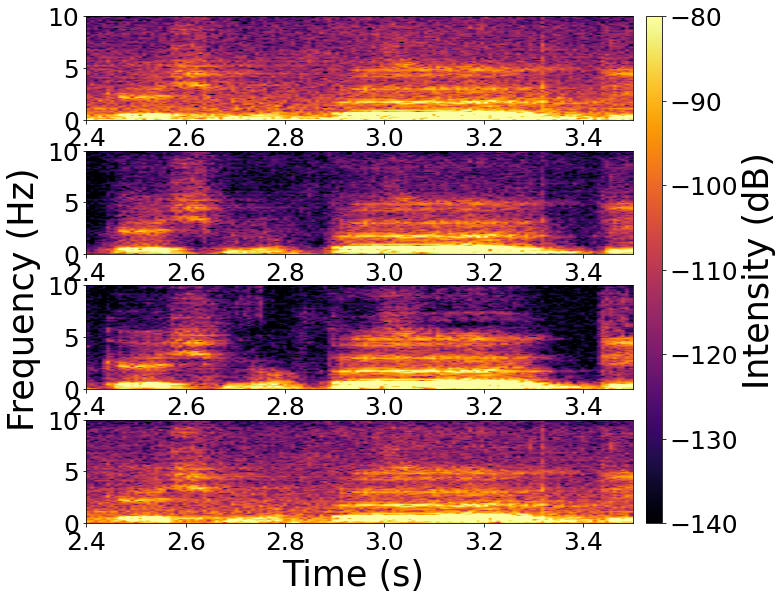

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


def get_spect(signal, title, ax):
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)

    # Plot the spectrogram on the specified axis
    im = ax.imshow(sxx, aspect="auto", cmap="inferno", vmin=-140, vmax=-80, extent=[2.4, 3.5, 10, 0])
    ax.invert_yaxis()
    ax.set_title(title, fontsize=39)
    # ax.set_xlabel("Time (s)", fontsize=25)
    # ax.set_ylabel("Frequency (Hz)", fontsize=25)
    ax.tick_params(axis="both", labelsize=25)
    return im


# Create a 4-row plot with a shared colorbar
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 2, width_ratios=[10, 0.3])  # Add an extra column for the colorbar

# Plot each spectrogram on a separate row
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[2, 0])
ax4 = plt.subplot(gs[3, 0])

# im1 = get_spect(array1_list[0], "Channel 1 of the original signal", ax1)
# # im2 = get_spect(beamformed_array1, "Signal after DAS Beamforming", ax2)
# im3 = get_spect(neural, "Signal after Joint Trained Neural Beamforming", ax2)
# im4 = get_spect(source, "Ground truth (aligned Headset)", ax3)
start_time=int(2.4*16000)
end_time=int(3.5*16000)
# im1 = get_spect(array1_list[0], "", ax1)
# im2 = get_spect(beamformed_array1, "", ax2)
# im3 = get_spect(neural, "", ax2)
# im4 = get_spect(source, "", ax3)
im1 = get_spect(array1_list[0][start_time:end_time], "", ax1)
im2 = get_spect(pretrained[start_time:end_time], "", ax2)
im3 = get_spect(source[start_time:end_time], "", ax3)
im4 = get_spect(neural[start_time:end_time], "", ax4)

# Set a common xlabel and ylabel
fig.text(0.5, 0.001, "Time (s)", ha="center", fontsize=35)  # Common xlabel
fig.text(
    0.02, 0.5, "Frequency (Hz)", va="center", rotation="vertical", fontsize=35
)  # Common ylabel


# Adjust layout to prevent clipping of axis labels and move the subplots inward
plt.subplots_adjust(left=0.13, right=0.99, top=0.99, bottom=0.11, hspace=0.3)


# Add a common colorbar to the right of the plots
cax = plt.subplot(gs[:, 1])
cbar = plt.colorbar(im4, cax=cax, label="Intensity (dB)")

# Manually adjust the position of the colorbar
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0 - 0.06, cax_pos.y0, cax_pos.width, cax_pos.height])

cbar.ax.yaxis.label.set_fontsize(35)
# Increase font size for colorbar
cbar.ax.tick_params(labelsize=25)
# Show the plot
plt.savefig("beanformers_joint.png", bbox_inches="tight")
plt.show()

In [31]:
print(neural[start_time:end_time].shape)

(0,)
